- We built our model as a subclass of `nn.Module`, the **de facto standard for all** but the simplest models.
- PyTorch ships with a very comprehensive collection of modules and loss functions to implement state-of-the-art architectures ranging from feed-forward components to long short-term memory (LSTM) modules and **transformer networks** (two very popular architectures for sequential data).

### 8.5.1 Adding memory capacity: Width
- The width of the network: **the number of neurons per layer, or channels per convolution**. widthの意味はchannel数だよ。

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

- Avoi hardcoding numbers:

In [4]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [5]:
model = NetWidth()
sum(p.numel() for p in model.parameters())

38386

### 8.5.2 Helping our model to converge and generalize: Regularization
- The mathematical tools aimed at easing optimization and generalization are sometimes subsumed(含める) under the label *regularization*.

#### Keeping the parameters in check: Weight penalties
- Weight penalties: make the loss have a smoother topography, and there's **relatively less to gain from fitting individual samples**.
- The negative gradient of the L2 regularization term with respect to a parameter `w_i` is `- 2 * lambda * w_i`.
    - So, adding L2 regularization to the loss function is equivalent to decreasing each weight by an amount proportional to its current value during the optimization step.
- Note that weight decay applies to all parameters of the network, such as biases.

In [6]:
device = (torch.device('cuda') if torch.cuda.is_available()
         else torch.device('cpu'))
device

device(type='cuda')

In [7]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                         for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch, loss_train / len(train_loader)))

- However, the SGD optimizer in PyTorch already has a `weight_decay` parameter that corresponds to `2 * lambda`, and it directly performs weight decay during the update.

#### Not relying too much on a single input: Dropout
- The idea: zero out a random fraction of outputs from neurons across the network, where the randomization happens at each training iteration.
- This procedure effectively generates slightly different models with different neuron topologies at each iteration, **giving neurons in the model less chance to coordinate in the memorization process** that happens during overfitting.
- An alternative point of view is that dropout **perturbs(摂動「せつどう」) the features** being generated by the model, exerting an effect that is close to augmentation, but this time throughout the network.
- `nn.Dropout`: as an argument, we need to specify the **probability with which inputs will be zeroed out**.
- In case of convolutions, we'll use the specialized `nn.Dropout2d` or `nn.Dropout3d`, which zero out entire channels of the input:

In [8]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

- Note that **dropout is normally active during training**, while during the evaluation of a trained model in production, dropout is bypassed or, equivalently, assigned a probability equal to zero.
- This is controlled throught the `train` property of the `Dropout` module.
- PyTorch lets us switch between the two modalities by calling `model.train()` or `model.eval()` on any `nn.Module` subclass.
    - The call will **automatically replicated on the submodules** so that if `Dropout` is among them, it will behave accordingly in subsequent forward and backward passes.
    
#### Keeping activations in check: Batch Normalization
- Batch normalizationのメリット：
    - Allowing us to **increase the learning rate and make training less dependent on initialization** and act as a regularizer, thus **representing an alternative to dropout**. なるほど、だからあんまりdropoutとbatch normを一緒に見たことがなさそう！
- idea: **rescale** the **inputs to the activations** of the network so that **minibatches have a certain desriable distribution**.
    - This helps avoid the inputs to activation functions **being too far into the saturated portion of the function**, thereby killing gradients and slowing training.
- In practical terms, batch normalization **shifts and scales** an **intermediate** input using the mean and standard deviation collected at that **intermediate** location over the samples of the minibatch.
    - The regularization effect is a result of the fact that **an individual sample and its downstream activations** are always **seen by the model as shifted and scaled**, depending on the statistics across the randomly extracted minibatch.
- The authors of the paper suggest that **using batch normalization eliminates or at least alleviates the need for dropout**.

In [9]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv2_batchnorm(self.conv2(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

- Just as for dropout, **batch normalization needs to behave differently during training and inference**.
- In fact, at inference time, we want to **avoid having the output for a specific input depend on the statistics of the other inputs** we're presenting to the model. 当然でしょう。推論するときは、sample一つ一つの結果がsampleだけの情報を使うべきでしょう。
- **As such, we need a way to still normalize, but this time fixing the normalization parameters once and for all**. どうやって？？
    - As minibatches are processed, **in addition to estimating the mean and standard deviation for the current minibatch, PyTorch also updates the running estimates for mean and standard deviation that are representative of the whole dataset, as an approximation**.
    - This way, when the user specifies **`model.eval()`** and the model contains a batch normalization module, **the running estimates are frozen and used for normalization**.
    - To **unfreeze running estimates and return to using the minibatch statistics**, we call **`model.train()`**, just as we did for dropout.
    
### 8.5.3 Going deeper to learn more complex structures: Depth
#### Skip Connections
- Depth comes with some additional challenges, which prevented deep learning models from reaching 20 or more layers until late 2015.
- **Adding depth to a model generally makes training harder to converge**.
- deep networkのbackpropagationにはlong chain of multiplicationsが存在する：tend to make the contribution of the parameter to the gradient vanish, leading to ineffective training of that layer since that parameter and others like it won't be properly updated.
- **residual networks (ResNets)**: opened the door to networks ranging from tens of layers to 100 layers in depth.
- The trick is using a skip connection to short-circuit blocks of layers:

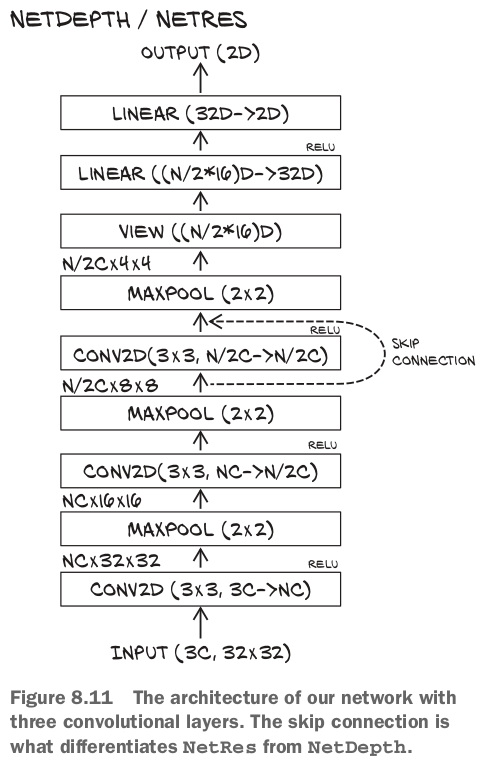

In [10]:
from PIL import Image
Image.open('img/skip-connection-2020-12-30-00-04-31.png')

- **A skip connection** is nothing but the **addition of the input to the output of a block of layers**.
- skip connectionをやる前：

In [11]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

- skip connectionを入れたら：（`forward`内やる）

In [12]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2) # ここだ！
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

- This is also referred to as **identity mapping**.
- How does this alleviate the issues with vanishing gradients we were mentioning earlier?
    - Creates a **direct path** from the deeper parameters to the loss.
    - This makes their contribution to the gradient of the loss more direct, as partial derivatives of the loss with respect to those parameters have a chance not to be multiplied by a long chain of other operations.
- It has been observed that skip connections have a beneficial effect on convergence **especially in the initial phases of training**.
    - Also, the **loss landscape** of deep residual networks is **a lot smoother** than feed-forward networks of the same depth and width.
    
#### Building very deep models in PyTorch
- 例えば100層ネットワーク：how can we build that network in PyTorch without losing our minds in the process? やり方：

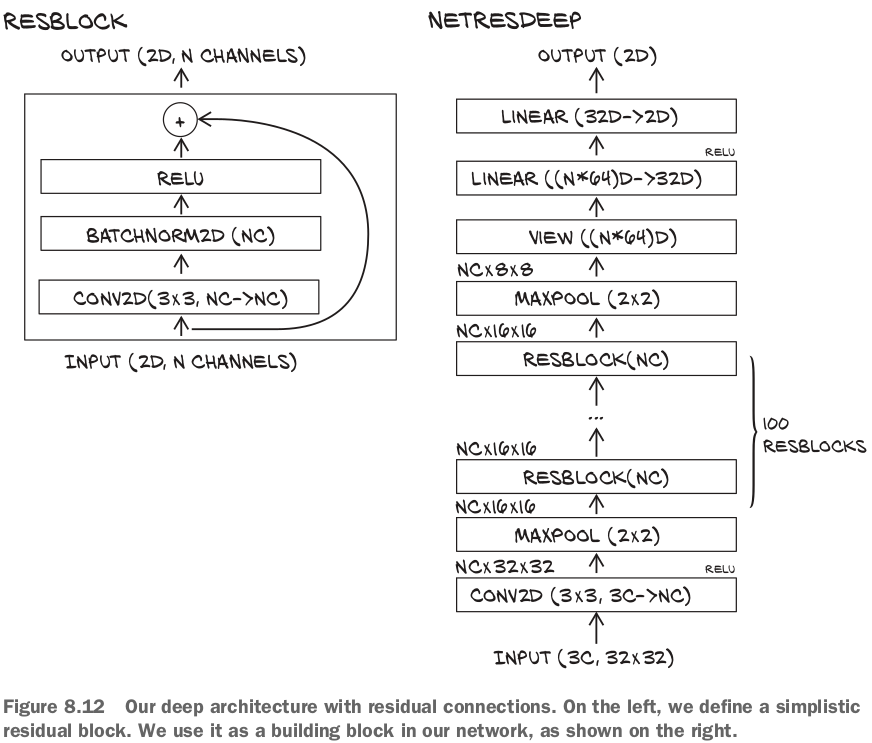

In [13]:
Image.open('img/deep-residual-network-2020-12-30-01-26-00.png')

In [14]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        # The BatchNorm layer would cancel the effect of bias, so it is customarily(習慣的に) left out.
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

- Since we're planning to generate a deep model, we are including batch normalization in the block, since this will help prevent gradients from vanishing during training.
- First, **in *init*, we create `nn.Sequential` containing a list of `ResBlock` instances**.
    - **`nn.Sequential` will ensure that the output of one block is used as input to the next**.
    - It will also ensure that **all the parameters in the block are visible to `Net`**.

In [15]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

#### Initialization
- Unfortunately, for historical reasons, PyTorch has default weight initializations that are not ideal.
- 初期化のテーマは大きい。

### 8.5.4 Comparing the designs from this section

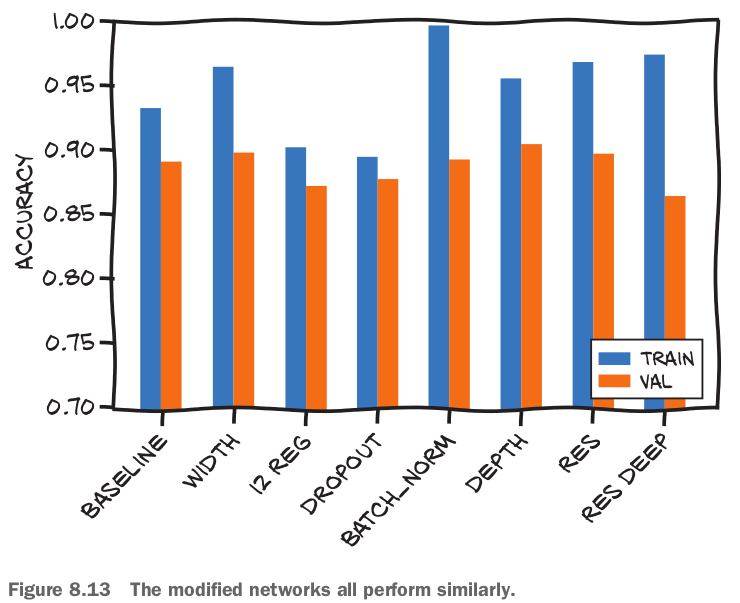

In [16]:
Image.open('img/performance-of-modification-2020-12-30-02-05-50.png')

- Batch norm, which **serves more as a convergence helper**, lets us train the network to nearly 100% training accuracy, so we interpret weight decay and dropout as regularization.

### 8.5.5 It's already outdated
- The take-home message is that we should make every effort to proficiently translate the math behind a paper into actual PyTorch code, or at least understand the code that others have written with the same intention.

## 8.6 Conclusions
- Creating bounding boxes around objects in an image is something a model like ours can't do.
- もう1つ課題、もし猫の写真だったら、it will happily output "airplane" or "bird", perhaps with 0.99 probability.
    - This issue of **being very confident about samples that are far from the training distribution is called overgeneralization**.
    - It's one of the main problems when we take a (presumably good) model to production in those cases **where we can't really trust the input** (which, sadly, **is the majority of real-world cases**).